<a href="https://colab.research.google.com/github/tillu1208/OpenCV/blob/main/09_01_Lane_detection_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-size:30px;">Lane Detection Pipeline for a Still Image</h1>

This notebook will help you create a pipeline for Lane Detection using OpenCV on a single frame. The use case in mind is a dashcam pointed at the road ahead of where a car is driving. In this notebook you will learn about Hough transforms and how to apply them to the use case of detecting lanes in a still image. At a high level, the pipeline takes these steps:

* Create a threshold for lane lines
* Selecting Region of Interest
* Detecting Edges using Canny Edge Detector
* Fit lines using Hough Line Transform
* Extrapolate the lanes from lines found
* Composite the result original frame

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

if 'google.colab' in str(get_ipython()):
    print("Downloading Code to Colab Environment")
    !wget https://www.dropbox.com/sh/93k0ei59i6p554o/AAD1WAU_u25zZCs5LqyBDhaZa?dl=1 -O module-code.zip -q --show-progress
    !unzip -qq module-code.zip
else:
    pass

module-code.zip     100%[===================>]  38.98M  46.1MB/s    in 0.8s    
mapname:  conversion of  failed


# 1. Create Threshold for Lane Lines

The first step in our workflow is to construct a general thresold that will isolate the lane lines from the asphalt. While the threshold will run over the entire image, we will later isolate our region of interest, so we do not need to worry about the sky and trees and other elements of the scene just yet.

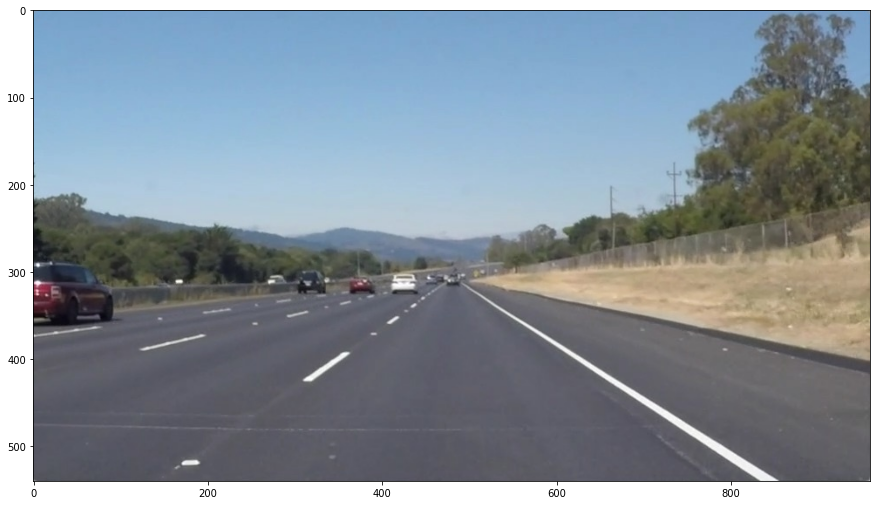

In [ ]:
# Reading the image.
img = cv2.imread('./test_img1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (15, 10))
plt.imshow(img);

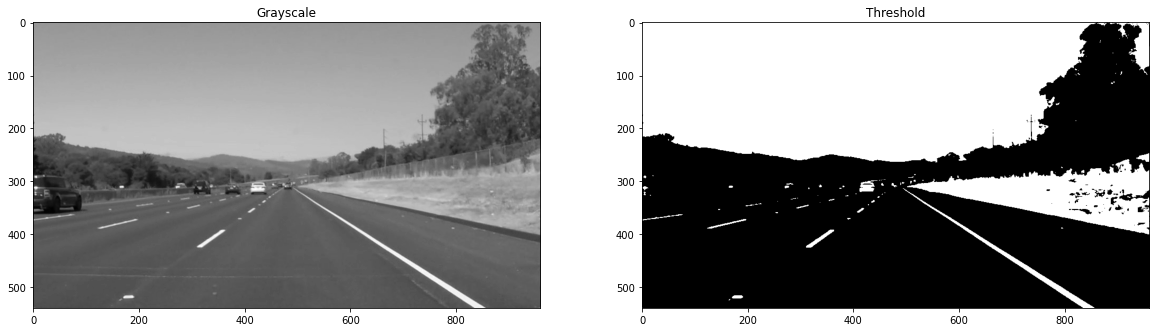

In [ ]:
# Convert to grayscale.
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Use global threshold based on grayscale intensity.
threshold = cv2.inRange(gray, 150, 255)

# Display images.
plt.figure(figsize = (20, 10))
plt.subplot(1,2,1); plt.imshow(gray, cmap = 'gray');      plt.title('Grayscale');
plt.subplot(1,2,2); plt.imshow(threshold, cmap = 'gray'); plt.title('Threshold');

# 2. Selecting the Region of Interest Using fillPoly()

We can observe that it's a trapezoid.

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

The `fillPoly()` function fills the area bounded by one or more polygons.

### <font style="color:rgb(8,133,37)">Function Syntax</font>
``` python
dst = cv2.fillPoly( img, pts, color[, lineType[, shift[, offset]]] )
```
`dst`: Is the output image of the same size and depth as `img`.

The function has **2 required input argument** and 4 optional arguments:

1. `image`: Input image.
2. `pts`: Array of polygons where each polygon is represented as an array of points.
3. `color`: Polygon color.
4. `lineType`: Type of the polygon boundaries.
5. `shift`: Number of fractional bits in the vertex coordinates.
6. `offset`: Optional offset of all points of the contours.

### <font style="color:rgb(8,133,37)">OpenCV Documentation</font>

[**`fillPoly()`**](https://docs.opencv.org/4.5.2/d6/d6e/group__imgproc__draw.html#ga311160e71d37e3b795324d097cb3a7dc)
                   
<hr style="border:none; height: 4px; background-color:#D3D3D3" />

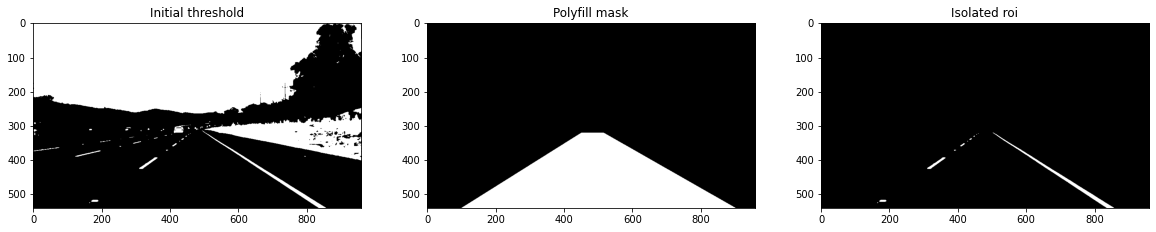

In [ ]:
 #  Region masking: Select vertices according to the input image.
roi_vertices = np.array([[[100, 540],
                          [900, 540],
                          [515, 320],
                          [450, 320]]])

# Defining a blank mask.
mask = np.zeros_like(threshold)

# Defining a 3 channel or 1 channel color to fill the mask.
if len(threshold.shape) > 2:
    channel_count = threshold.shape[2]  # 3 or 4 depending on the image.
    ignore_mask_color = (255,) * channel_count
else:
    ignore_mask_color = 255

# Filling pixels inside the polygon.
cv2.fillPoly(mask, roi_vertices, ignore_mask_color)

# Constructing the region of interest based on where mask pixels are nonzero.
roi = cv2.bitwise_and(threshold, mask)

# Display images.
plt.figure(figsize = (20, 10))
plt.subplot(1,3,1); plt.imshow(threshold, cmap = 'gray'); plt.title('Initial threshold')
plt.subplot(1,3,2); plt.imshow(mask, cmap = 'gray');      plt.title('Polyfill mask')
plt.subplot(1,3,3); plt.imshow(roi, cmap = 'gray');       plt.title('Isolated roi');

# 3. Detect Edges and Smooth Noise

Next we need to identify the edges in the image. We can use the Canny edge detection to identify the lane lines, followed by a Gaussian blur to smooth out any noise remaining after the edge detection.

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

### <font style="color:rgb(8,133,37)">OpenCV Documentation</font>

[**`Canny()`**](https://docs.opencv.org/4.5.2/dd/d1a/group__imgproc__feature.html#ga04723e007ed888ddf11d9ba04e2232de)
[**`GaussianBlur()`**](https://docs.opencv.org/4.5.2/d4/d86/group__imgproc__filter.html#gaabe8c836e97159a9193fb0b11ac52cf1)

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

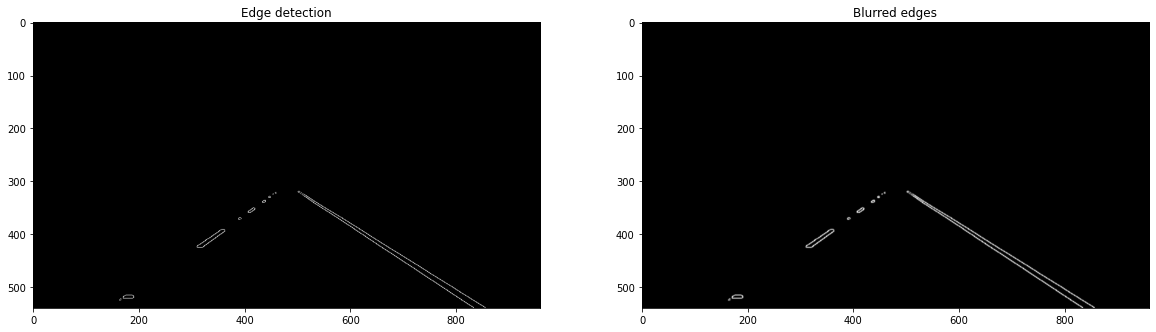

In [ ]:
# Perform Edge Detection.
low_threshold = 50
high_threshold = 100
edges = cv2.Canny(roi, low_threshold, high_threshold)

# Smooth with a Gaussian blur.
kernel_size = 3
canny_blur = cv2.GaussianBlur(edges, (kernel_size, kernel_size), 0)

# Display images.
plt.figure(figsize = (20, 10))
plt.subplot(1,2,1); plt.imshow(edges, cmap = 'gray'); plt.title('Edge detection')
plt.subplot(1,2,2); plt.imshow(canny_blur, cmap = 'gray'); plt.title('Blurred edges');

# 4. Line Detection Using HoughLinesP()

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

`HoughLinesP()` finds line segments in a binary image using the probabilistic Hough transform. The function implements the probabilistic Hough transform algorithm for line detection.

### <font style="color:rgb(8,133,37)">Function Syntax</font>
``` python
lines = cv2.HoughLinesP( image, rho, theta, threshold[, lines[, minLineLength[, maxLineGap]]] )
```
`lines`: Output vector of lines. Each line is represented by a 4-element vector (x1,y1,x2,y2) , where (x1,y1) and (x2,y2) are the ending points of each detected line segment.

The function has **4 required input argument**:

1. `image`: 8-bit, single-channel binary source image.
2. `rho`: Distance resolution of the accumulator in pixels.
3. `theta`: Angle resolution of the accumulator in radians.
4. `threshold`: returns only those lines which are greater than threshold.
5. `minLineLength`: Minimum line length. Line segments shorter than that are rejected.
6. `maxLineGap`: Maximum allowed gap between points on the same line to link them.

### <font style="color:rgb(8,133,37)">OpenCV Documentation</font>

[**`HoughLinesP()`**](https://docs.opencv.org/4.5.2/dd/d1a/group__imgproc__feature.html#ga8618180a5948286384e3b7ca02f6feeb)
[**`line()`**](https://docs.opencv.org/4.5.2/d6/d6e/group__imgproc__draw.html#ga7078a9fae8c7e7d13d24dac2520ae4a2)

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

In [ ]:
def draw_lines(img, lines, color = [255, 0, 0], thickness = 2):
    """Utility for drawing lines."""
    if lines is not None:
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

Found 21 lines, including: [[500 318 853 539]]


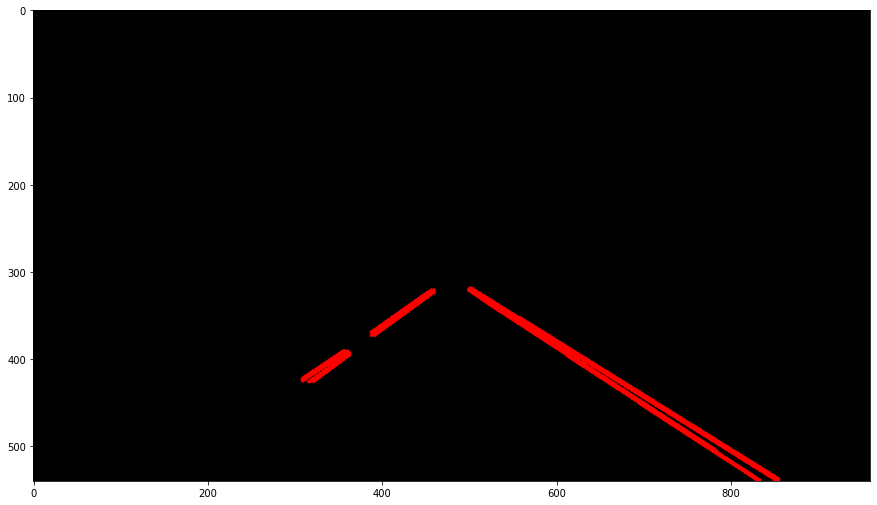

In [ ]:
# Hough transform parameters set according to the input image.
rho = 1
theta = np.pi / 180
threshold = 50
min_line_len = 10
max_line_gap = 20

lines = cv2.HoughLinesP(
    canny_blur, rho, theta, threshold, minLineLength = min_line_len, maxLineGap = max_line_gap)

# Draw all lines found onto a new image.
hough = np.zeros((img.shape[0], img.shape[1], 3), dtype = np.uint8)
draw_lines(hough, lines)

print("Found {} lines, including: {}".format(len(lines), lines[0]))
plt.figure(figsize = (15, 10)); plt.imshow(hough);

# 5. Separate Sides and Extrapolate

### <font style='color:rgb(50,120,230)'> 5.1 Function for separating left and right lines depending on the slope </font>

We need to look at all the lines and determine if they are contributing to the left or right lane lines. As y coordinates increase in value from top to bottom, a line with a positive slope is part of the right lane, and a negative slope means the left lane. Therefore, if `y1 > y2` we have left lane, and if `y1 < y2` we have right lane.

In [ ]:
def separate_left_right_lines(lines):
    """Separate left and right lines depending on the slope."""
    left_lines = []
    right_lines = []
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                if y1 > y2: # Negative slope = left lane.
                    left_lines.append([x1, y1, x2, y2])
                elif y1 < y2: # Positive slope = right lane.
                    right_lines.append([x1, y1, x2, y2])
    return left_lines, right_lines

### <font style='color:rgb(50,120,230)'> 5.2 Function to calculate average which will be used in extrapolating lines </font>

In [ ]:
def cal_avg(values):
    """Calculate average value."""
    if not (type(values) == 'NoneType'):
        if len(values) > 0:
            n = len(values)
        else:
            n = 1
        return sum(values) / n

### <font style='color:rgb(50,120,230)'> 5.3 Function to extrapolate lines </font>

As some lane lines are only partially recognized. We should extrapolate the line to cover full lane line length.
We must keep in mind the lower and upper border intersections to find the full lane line length.

In [ ]:
def extrapolate_lines(lines, upper_border, lower_border):
    """Extrapolate lines keeping in mind the lower and upper border intersections."""
    slopes = []
    consts = []

    if lines is not None:
        for x1, y1, x2, y2 in lines:
            slope = (y1-y2) / (x1-x2)
            slopes.append(slope)
            c = y1 - slope * x1
            consts.append(c)
    avg_slope = cal_avg(slopes)
    avg_consts = cal_avg(consts)

    # Calculate average intersection at lower_border.
    x_lane_lower_point = int((lower_border - avg_consts) / avg_slope)

    # Calculate average intersection at upper_border.
    x_lane_upper_point = int((upper_border - avg_consts) / avg_slope)

    return [x_lane_lower_point, lower_border, x_lane_upper_point, upper_border]

 ### <font style='color:rgb(50,120,230)'> 5.4 Extract extrapolated lanes and draw lane lines </font>

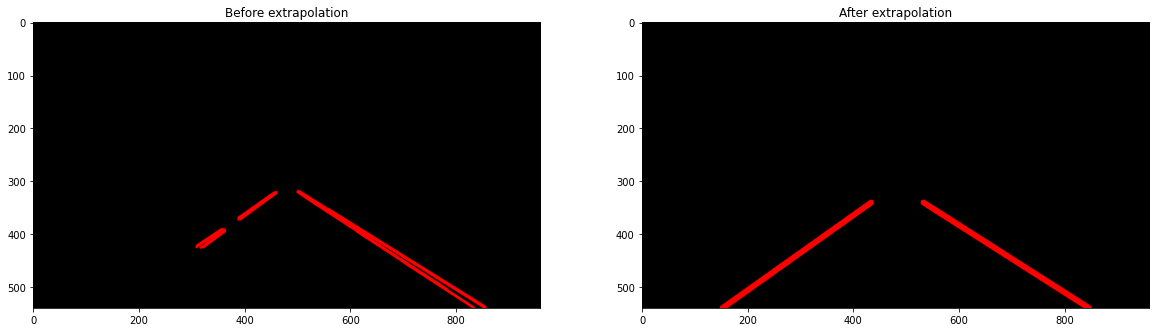

In [ ]:
# Define bounds of the region of interest.
roi_upper_border = 340
roi_lower_border = 540

# Create a blank array to contain the (colorized) results.
lanes_img = np.zeros((img.shape[0], img.shape[1], 3), dtype = np.uint8)

# Use above defined function to identify lists of left-sided and right-sided lines.
lines_left, lines_right = separate_left_right_lines(lines)

# Use above defined function to extrapolate the lists of lines into recognized lanes.
lane_left = extrapolate_lines(lines_left, roi_upper_border, roi_lower_border)
lane_right = extrapolate_lines(lines_right, roi_upper_border, roi_lower_border)
draw_lines(lanes_img, [[lane_left]], thickness = 10)
draw_lines(lanes_img, [[lane_right]], thickness = 10)

# Display results.
fig = plt.figure(figsize = (20, 20))
ax = fig.add_subplot(1, 2, 1); plt.imshow(hough); ax.set_title('Before extrapolation')
ax = fig.add_subplot(1, 2, 2); plt.imshow(lanes_img); ax.set_title('After extrapolation');
plt.show()

# 6. Blend Results Together

As a final step, we can combine the detected lanes with the original image of the road.

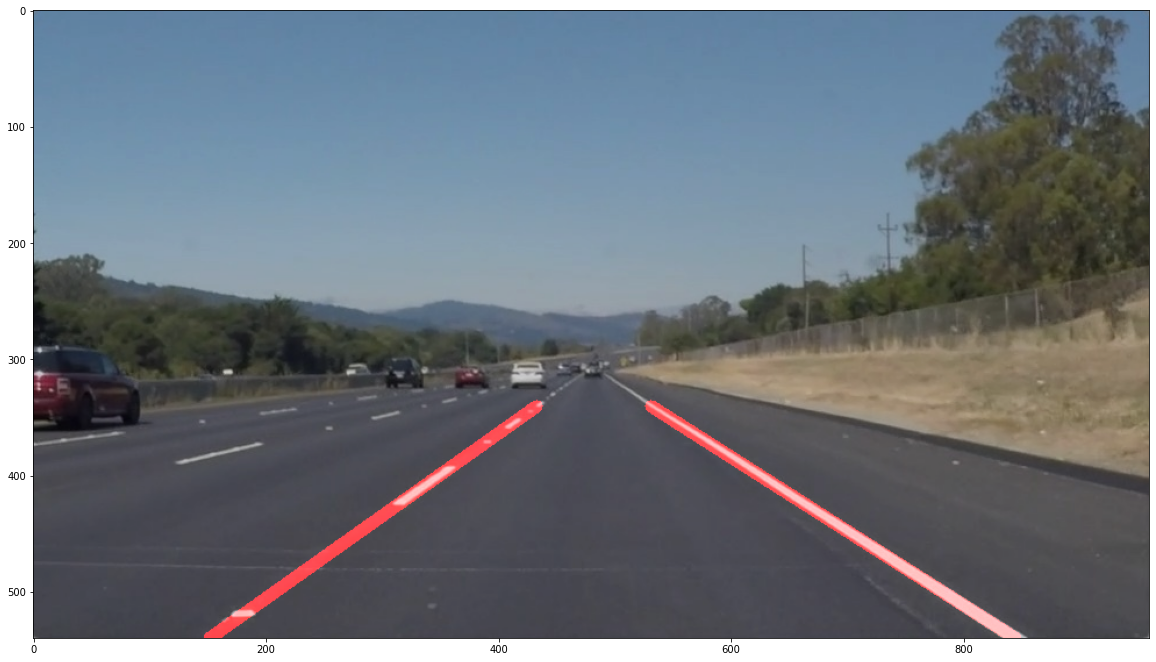

In [ ]:
alpha = 0.8
beta = 1.0
gamma = 0.0
image_annotated = cv2.addWeighted(img, alpha, lanes_img, beta, gamma)

# Display the results, and save image to file.
fig = plt.figure(figsize = (20, 20))
plt.imshow(image_annotated)
image_annotated = cv2.cvtColor(image_annotated, cv2.COLOR_BGR2RGB)
cv2.imwrite('./Lane1-image.jpg', image_annotated);